In [21]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def plot_metrics_for_models(results_list, dataset_title):
    """for testing"""
    plt.figure(figsize=(10, 6))
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    metrics = ['acc', 'prec', 'recall', 'specificity']
    num_metrics = len(metrics)
    num_models = len(model_names)
 
    metric_values = np.zeros((num_models, num_metrics))
    for i, results in enumerate(results_list):
        for j, metric in enumerate(metrics):
            metric_values[i, j] = results['test_'+metric]
    bar_width = 0.15
    index = np.arange(num_models)
    plt.figure(figsize=(10, 6))
    for i in range(num_metrics):
        plt.bar(index + i * bar_width, metric_values[:, i], bar_width, label=metrics[i])

    plt.xlabel('Model Types')
    plt.ylabel('Values')
    plt.title(f'Metrics Across Model Types: {dataset_title}')
    plt.xticks(index + bar_width * (num_metrics - 1) / 2, model_names)
    plt.legend()
    plt.show()

In [23]:
def plot_metrics_for_sampling(results_list, dataset_title):
    """for testing"""
    plt.figure(figsize=(12, 8))
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    metrics = ['acc', 'prec', 'recall', 'specificity']
    num_metrics = len(metrics)
    num_models = len(model_names)
    num_datasets = len(results_lists)
    metric_values = np.zeros((num_models, num_metrics))
    bar_width = 0.15
    index = np.arange(num_models)

    for i in range(num_datasets):
        plt.subplot(num_datasets, 1, i+1)
        metric_values = np.zeros((num_models, num_metrics))
        for j, results in enumerate(results_lists[i]):
            for k, metric in enumerate(metrics):
                metric_values[j, k] = results['test_'+metric]

        for l in range(num_metrics):
            plt.bar(index + l * bar_width, metric_values[:, l], bar_width, label=metrics[l])

        plt.xlabel('Model Types')
        plt.ylabel('Values')
        plt.title(f'Metrics Across Model Types: {dataset_titles[i]}')
        plt.xticks(index + bar_width * (num_metrics - 1) / 2, model_names)
        plt.legend()
        
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show(); 

In [24]:
def plot_metrics_for_models2(results_lists, titles):
    plt.figure(figsize=(12, 8))
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    metrics = ['acc', 'prec', 'recall', 'specificity']
    num_metrics = len(metrics)
    num_models = len(model_names)
    num_datasets = len(results_lists)

    bar_width = 0.15
    index = np.arange(num_models)
    for i in range(num_models):
        plt.subplot(num_models, 1, i+1)
        metric_values = np.zeros((num_datasets, num_metrics))
        for j, results_list in enumerate(results_lists):
            for k, metric in enumerate(metrics):
                metric_values[j, k] = results_list[i]['test_'+metric]

        for l in range(num_metrics):
            plt.bar(index + l * bar_width, metric_values[:, l], bar_width, label=metrics[l])

        plt.xlabel('Sampling Techniques')
        plt.ylabel('Values')
        plt.title(f'Metrics Across Sampling Techniques for Model Type: {model_names[i]}')
        plt.xticks(index + bar_width * (num_metrics - 1) / 2, dataset_titles)
        plt.legend()
        
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show();


In [5]:
def plot_chosen_metric(results_lists, metric, title):
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    sampling_techniques = ['Original', 'Undersampled', 'SMOTE', 'ADASYN']
    # metrics = ['acc', 'prec', 'recall', 'specificity']
    plt.figure(figsize=(10, 6))
    # for i, model_name in enumerate(model_names):
    #     metric_values = []
    #     for j, results_list in enumerate(results_lists):
    #         metric_values.append(results_list[j]['test_'+metric])

    #     plt.plot(sampling_techniques, metric_values, label=model_name)
    for i, model_results in enumerate(results_lists):
        metric_values = [result['test_'+metric] for result in model_results]
        plt.plot(sampling_techniques, metric_values, label=model_names[i])
    plt.xlabel('Sampling type')
    plt.ylabel('Value')
    plt.title(f'{metric} Results: {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [25]:
modeldir = 'saved_models/'

# Load datasets
(MOE descriptors, just scaled)

In [28]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/inhib/'
train_x_df = pd.read_csv(split_path + 'inhib_train_x_scaledoriginal.csv', header=None)
train_y_df = pd.read_csv(split_path + 'inhib_train_y_scaledoriginal.csv', header=None)
test_y_df = pd.read_csv(split_path + 'inhib_test_y_scaledoriginal.csv', header=None)
test_x_df = pd.read_csv(split_path + 'inhib_test_x_scaledoriginal.csv', header=None)
train_x = train_x_df.values
train_y = train_y_df.values.flatten()
test_y = test_y_df.values.flatten()
test_x = test_x_df.values
train_x.shape, train_y.shape, test_y.shape, test_x.shape

((1636, 306), (1636,), (408,), (408, 306))

In [31]:
# UNDER 
train_x_df_UNDER = pd.read_csv(split_path + 'inhib_train_x_UNDER.csv', header=None)
train_y_df_UNDER = pd.read_csv(split_path + 'inhib_train_y_UNDER.csv', header=None)
test_y_df_UNDER = pd.read_csv(split_path + 'inhib_test_y_UNDER.csv', header=None)
test_x_df_UNDER = pd.read_csv(split_path + 'inhib_test_x_UNDER.csv', header=None)
train_x_UNDER = train_x_df_UNDER.values
train_y_UNDER = train_y_df_UNDER.values.flatten()
test_y_UNDER= test_y_df_UNDER.values.flatten()
test_x_UNDER = test_x_df_UNDER.values

In [32]:
# SMOTE 
train_x_df_SMOTE = pd.read_csv(split_path + 'inhib_train_x_SMOTE.csv', header=None)
train_y_df_SMOTE = pd.read_csv(split_path + 'inhib_train_y_SMOTE.csv', header=None)
test_y_df_SMOTE = pd.read_csv(split_path + 'inhib_test_y_SMOTE.csv', header=None)
test_x_df_SMOTE = pd.read_csv(split_path + 'inhib_test_x_SMOTE.csv', header=None)
train_x_SMOTE = train_x_df_SMOTE.values
train_y_SMOTE = train_y_df_SMOTE.values.flatten()
test_y_SMOTE= test_y_df_SMOTE.values.flatten()
test_x_SMOTE = test_x_df_SMOTE.values

In [33]:
# ADASYN
train_x_df_ADASYN = pd.read_csv(split_path + 'inhib_train_x_ADASYN.csv', header=None)
train_y_df_ADASYN = pd.read_csv(split_path + 'inhib_train_y_ADASYN.csv', header=None)
test_y_df_ADASYN = pd.read_csv(split_path + 'inhib_test_y_ADASYN.csv', header=None)
test_x_df_ADASYN = pd.read_csv(split_path + 'inhib_test_x_ADASYN.csv', header=None)
train_x_ADASYN = train_x_df_ADASYN.values
train_y_ADASYN = train_y_df_ADASYN.values.flatten()
test_y_ADASYN= test_y_df_ADASYN.values.flatten()
test_x_ADASYN = test_x_df_ADASYN.values

In [34]:
# brf_model_BCW_SMOTE = rf_models(train_x_SMOTE, train_y_SMOTE, test_x_SMOTE, test_y_SMOTE, 'balanced class_weight', {}, 'inhibition')
# plot_confusion_matrix(test_y_SMOTE, brf_model_BCW_SMOTE['test_pred'], ['0','1'], title='SMOTE NEK2 Binding Train: Basic RF')



TRAIN: accuracy: 0.983, precision: 0.999, recall: 0.967, sensitivity: 0.967, specificity: 0.999
TEST: accuracy: 0.934, precision: 0.517, recall: 0.536, sensitivity: 0.536, specificity: 0.963


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Axes: title={'center': 'SMOTE NEK2 Inhib Test: RF + Balanced Class Weight'}, xlabel='Predicted label', ylabel='True label'>

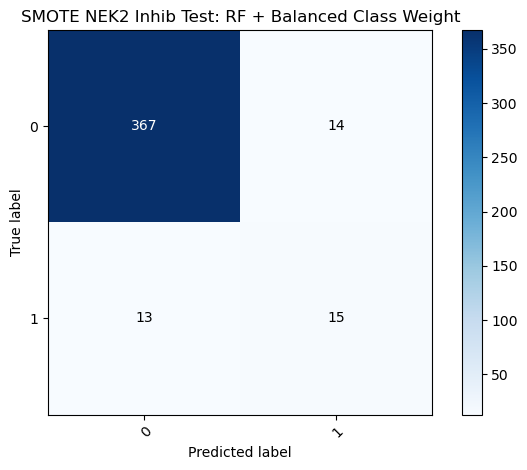

In [19]:
with open('atom_nek2inhibSMOTE_rf_basicBCW_best.pkl', 'rb') as f: 
    inhib_basicBCW = pickle.load(f)
basic_BCWresults = rf_results2(inhib_basicBCW, train_x_SMOTE, train_y_SMOTE, test_x_SMOTE, test_y_SMOTE)

plot_confusion_matrix(test_y_SMOTE, basic_BCWresults['test_pred'], ['0','1'], title='SMOTE NEK2 Inhib Test: RF + Balanced Class Weight')

{'default_RF':rf_basic100estUNDER['model'], 'rf_bcw':brf_model_BCW_UNDER['model'],
                              'BRFC':brf_modelUNDER['model'], 'BRFC_bcw':brf_modelCWB_UNDER['model']}
 temp_nek2bind_MOE_SMOTE = {'default_RF':rf_basic100estSMOTE['model'],
                            'rf_bcw':brf_model_BCW_SMOTE['model'],
                             'BRFC': brf_modelSMOTE['model'],
                            'BRFC_bcw':brf_modelCWB_SMOTE['model']}
 temp_nek2bind_MOE_ADASYN = {'default_RF':rf_basic100estADASYN['model'],
                            'rf_bcw':brf_model_BCW_ADASYN['model'],
                             'BRFC': brf_modelADASYN['model'],
                            'BRFC_bcw':brf_modelCWB_ADASYN['model']} -->

In [51]:
# filenames = ['temp_nek2inhib_originalmodels.pkl', 'temp_nek2inhib_UNDERmodels.pkl',
#              'temp_nek2inhib_SMOTEmodels.pkl', 'temp_nek2bind_SMOTEmodels.pkl'] 
# new 
filenames = ['nek2inhib_models.pkl', 'nek2inhib_UNDERmodels.pkl',
             'nek2inhib_SMOTEmodels.pkl', 'nek2bind_ADASYNmodels.pkl'] 
inhib_models = [] 
for i, val in enumerate(filenames):
    with open(filenames[i], 'rb') as f: 
        model = pickle.load(f)
    inhib_models.append(model)
inhib_original = inhib_models[0] 
inhib_under = inhib_models[1] 
inhib_smote = inhib_models[2] 
inhib_adasyn = inhib_models[3] 

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [52]:
test_x.shape, test_y.shape

((408, 306), (408,))

TRAIN: accuracy: 0.971, precision: 0.856, recall: 0.688, sensitivity: 0.688, specificity: 0.991
TEST: accuracy: 0.975, precision: 0.909, recall: 0.714, sensitivity: 0.714, specificity: 0.995
TRAIN: accuracy: 0.983, precision: 0.868, recall: 0.884, sensitivity: 0.884, specificity: 0.990
TEST: accuracy: 0.998, precision: 0.966, recall: 1.000, sensitivity: 1.000, specificity: 0.997
TRAIN: accuracy: 0.971, precision: 0.856, recall: 0.688, sensitivity: 0.688, specificity: 0.991
TEST: accuracy: 0.975, precision: 0.909, recall: 0.714, sensitivity: 0.714, specificity: 0.995
TRAIN: accuracy: 0.982, precision: 0.861, recall: 0.884, sensitivity: 0.884, specificity: 0.990
TEST: accuracy: 0.998, precision: 0.966, recall: 1.000, sensitivity: 1.000, specificity: 0.997


<Figure size 1000x600 with 0 Axes>

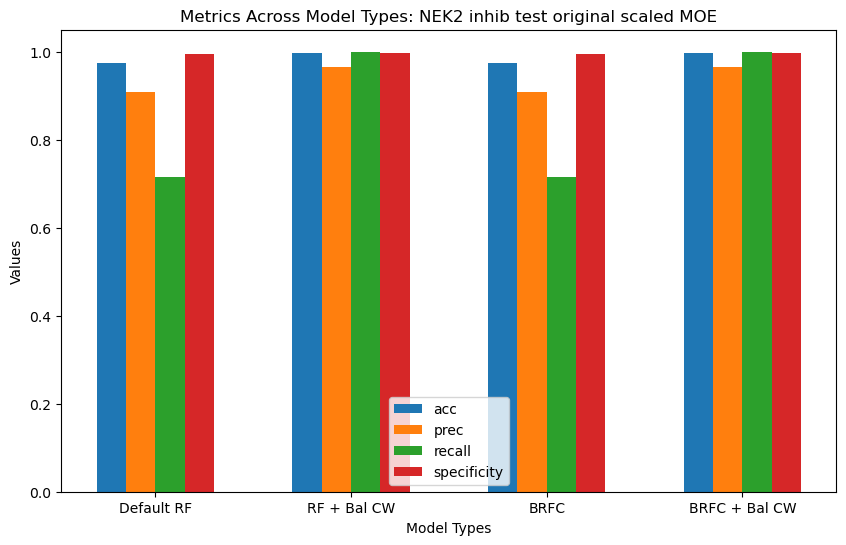

In [53]:
# do each model type: default rf, rf+bal cw, brfc, brfc+bal cw
inhib_original_results = [] 
for model_type, model in inhib_original.items():
    results = rf_results2(model, train_x, train_y, test_x, test_y)
    inhib_original_results.append(results)
plot_metrics_for_models(inhib_original_results, 'NEK2 inhib test original scaled MOE')

TRAIN: accuracy: 0.884, precision: 0.816, recall: 0.991, sensitivity: 0.991, specificity: 0.777
TEST: accuracy: 0.812, precision: 0.231, recall: 0.750, sensitivity: 0.750, specificity: 0.816
TRAIN: accuracy: 0.879, precision: 0.810, recall: 0.991, sensitivity: 0.991, specificity: 0.768
TEST: accuracy: 0.807, precision: 0.226, recall: 0.750, sensitivity: 0.750, specificity: 0.811
TRAIN: accuracy: 0.879, precision: 0.810, recall: 0.991, sensitivity: 0.991, specificity: 0.768
TEST: accuracy: 0.809, precision: 0.228, recall: 0.750, sensitivity: 0.750, specificity: 0.814
TRAIN: accuracy: 0.879, precision: 0.810, recall: 0.991, sensitivity: 0.991, specificity: 0.768
TEST: accuracy: 0.807, precision: 0.226, recall: 0.750, sensitivity: 0.750, specificity: 0.811


<Figure size 1000x600 with 0 Axes>

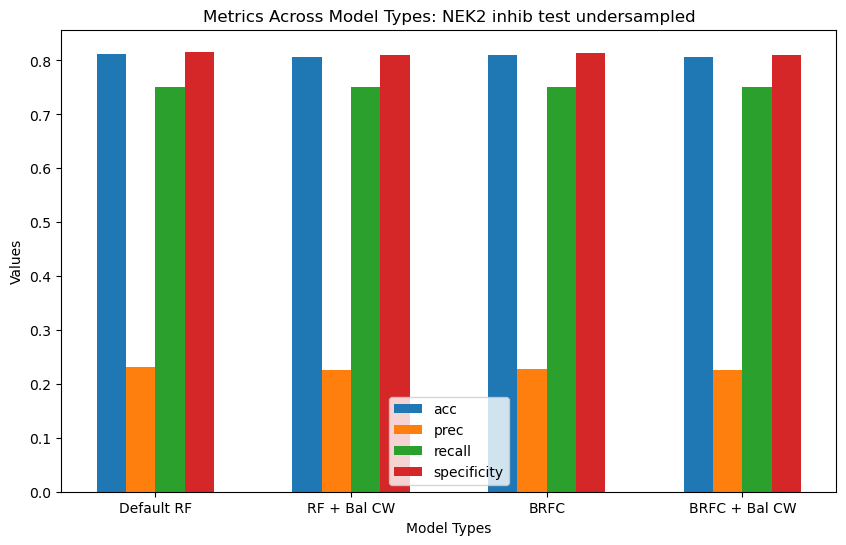

In [54]:
inhib_under_results = [] 
for model_type, model in inhib_under.items():
    results = rf_results2(model, train_x_UNDER, train_y_UNDER, test_x_UNDER, test_y_UNDER)
    inhib_under_results.append(results)
plot_metrics_for_models(inhib_under_results, 'NEK2 inhib test undersampled')

TRAIN: accuracy: 0.985, precision: 1.000, recall: 0.970, sensitivity: 0.970, specificity: 1.000
TEST: accuracy: 0.932, precision: 0.500, recall: 0.536, sensitivity: 0.536, specificity: 0.961
TRAIN: accuracy: 0.983, precision: 0.999, recall: 0.967, sensitivity: 0.967, specificity: 0.999
TEST: accuracy: 0.934, precision: 0.517, recall: 0.536, sensitivity: 0.536, specificity: 0.963
TRAIN: accuracy: 0.984, precision: 1.000, recall: 0.967, sensitivity: 0.967, specificity: 1.000
TEST: accuracy: 0.932, precision: 0.500, recall: 0.536, sensitivity: 0.536, specificity: 0.961
TRAIN: accuracy: 0.989, precision: 1.000, recall: 0.977, sensitivity: 0.977, specificity: 1.000
TEST: accuracy: 0.939, precision: 0.556, recall: 0.536, sensitivity: 0.536, specificity: 0.969


<Figure size 1000x600 with 0 Axes>

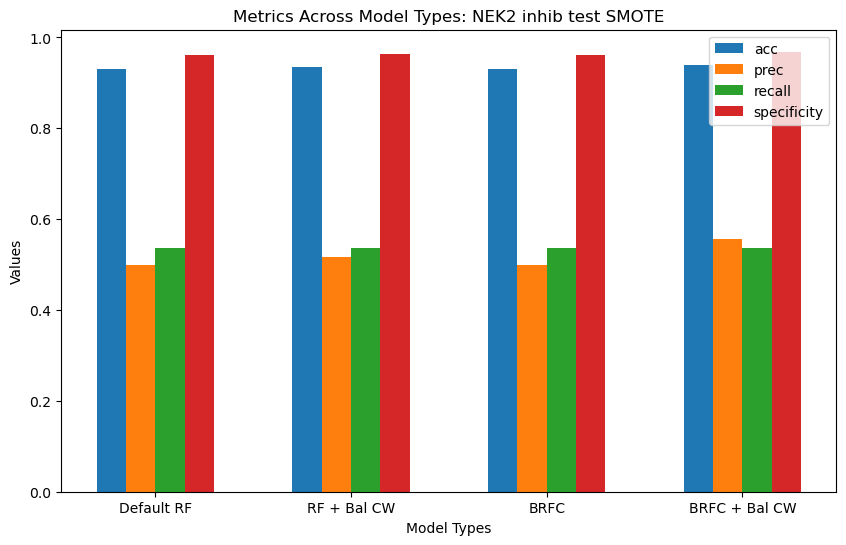

In [55]:
inhib_smote_results = [] 
for model_type, model in inhib_smote.items():
    results = rf_results2(model, train_x_SMOTE, train_y_SMOTE, test_x_SMOTE, test_y_SMOTE)
    inhib_smote_results.append(results)
plot_metrics_for_models(inhib_smote_results, 'NEK2 inhib test SMOTE')

TRAIN: accuracy: 0.620, precision: 0.664, recall: 0.483, sensitivity: 0.483, specificity: 0.756
TEST: accuracy: 0.753, precision: 0.108, recall: 0.357, sensitivity: 0.357, specificity: 0.782
TRAIN: accuracy: 0.603, precision: 0.652, recall: 0.434, sensitivity: 0.434, specificity: 0.770
TEST: accuracy: 0.763, precision: 0.103, recall: 0.321, sensitivity: 0.321, specificity: 0.795
TRAIN: accuracy: 0.625, precision: 0.672, recall: 0.483, sensitivity: 0.483, specificity: 0.765
TEST: accuracy: 0.751, precision: 0.098, recall: 0.321, sensitivity: 0.321, specificity: 0.782
TRAIN: accuracy: 0.569, precision: 0.655, recall: 0.287, sensitivity: 0.287, specificity: 0.850
TEST: accuracy: 0.812, precision: 0.123, recall: 0.286, sensitivity: 0.286, specificity: 0.850


<Figure size 1000x600 with 0 Axes>

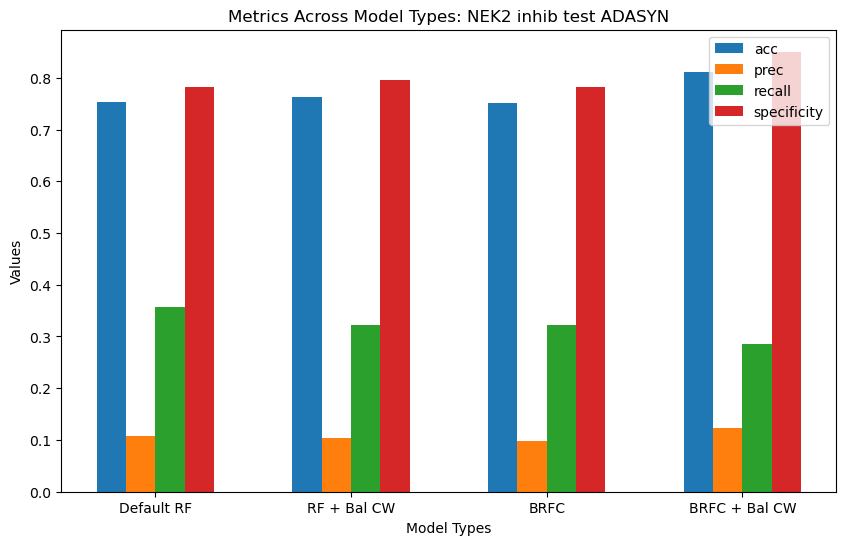

In [56]:
inhib_adasyn_results = [] 
for model_type, model in inhib_adasyn.items():
    results = rf_results2(model, train_x_ADASYN, train_y_ADASYN, test_x_ADASYN, test_y_ADASYN)
    inhib_adasyn_results.append(results)
plot_metrics_for_models(inhib_adasyn_results, 'NEK2 inhib test ADASYN')

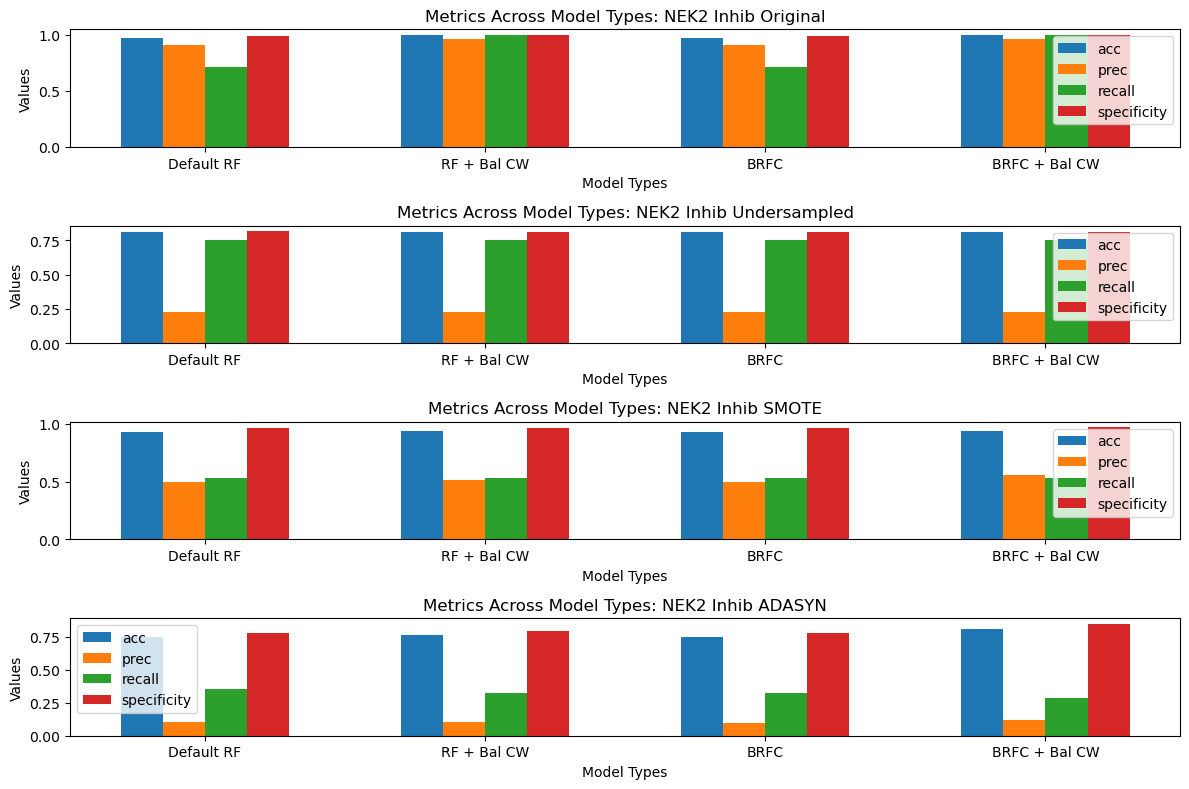

In [57]:
results_lists = [inhib_original_results, inhib_under_results, inhib_smote_results, inhib_adasyn_results]
dataset_titles = ['NEK2 Inhib Original', 'NEK2 Inhib Undersampled', 'NEK2 Inhib SMOTE', 'NEK2 Inhib ADASYN']

plot_metrics_for_sampling(results_lists, dataset_titles)


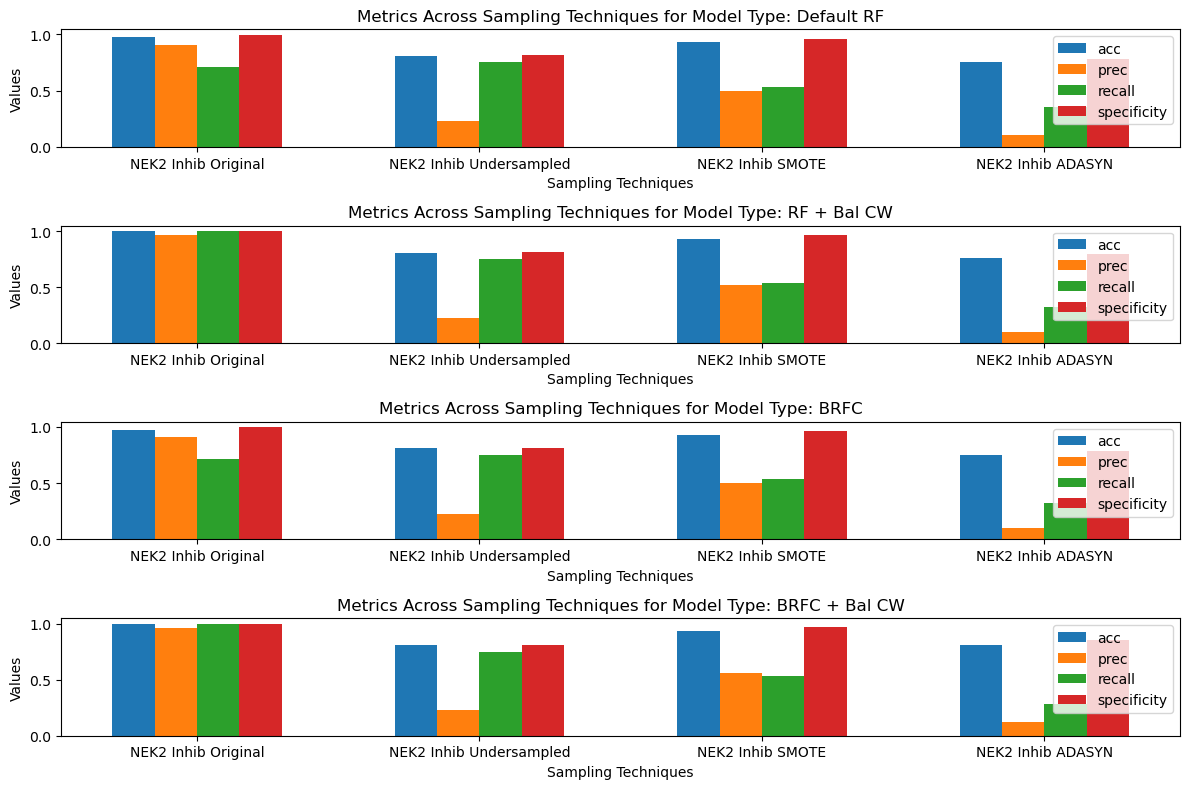

In [58]:
plot_metrics_for_models2(results_lists, dataset_titles)

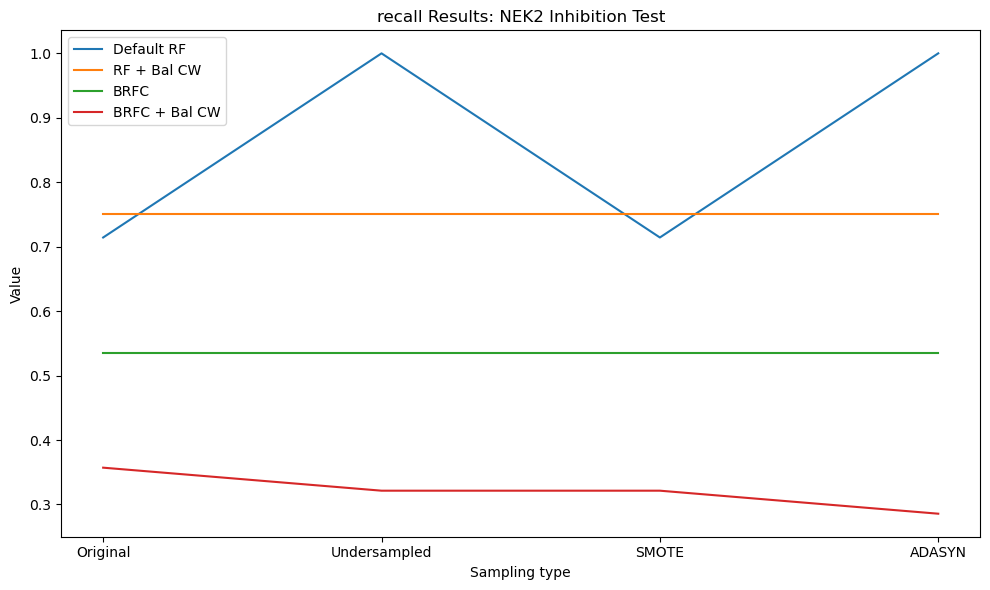

In [59]:


plot_chosen_metric(results_lists, 'recall', 'NEK2 Inhibition Test')

In [60]:
# temp_nek2bind_MOE_original = {'default_RF':rf_basic100est['model'], 'rf_bcw':brf_model_BCW['model'],
#                               'BRFC': brf_model['model'], 'BRFC_bcw':brf_modelCWB['model']}

# with open('temp_nek2bind_originalmodels.pkl', 'wb') as f:
#     pickle.dump(temp_nek2bind_MOE_original, f)

# Inhibition 

In [ ]:
# temp_nek2inhib_MOE_original = {'default_RF':rf_basic100est['model'],
#                                'rf_bcw':brf_model_BCW['model'],
#                               'BRFC': brf_model['model'],
#                                'BRFC_bcw':brf_modelCWB['model']}

# with open('temp_nek2inhib_originalmodels.pkl', 'wb') as f:
#     pickle.dump(temp_nek2inhib_MOE_original, f)
# with open('temp_nek2inhib_originalmodels.pkl', 'rb') as f:
#     temp_nek2inhib_MOE_original = pickle.load(f)

temp_nek2inhib_MOE = {'default_RF':rf_basic100est['model'],
                            'rf_bcw':brf_model_BCW['model'],
                             'BRFC': brf_model['model'],
                            'BRFC_bcw':brf_modelCWB['model']}

# with open('temp_nek2inhib_originalmodels.pkl', 'wb') as f: 
#     pickle.dump(temp_nek2inhib_MOE_SMOTE, f)

temp_nek2inhib_UNDER = {'default_RF':rf_basic100estUNDER['model'],
                               'rf_bcw':brf_model_BCW_UNDER['model'],
                              'BRFC': brf_modelUNDER['model'],
                               'BRFC_bcw':brf_modelCWB_UNDER['model']}

# with open('temp_nek2inhib_UNDERmodels.pkl', 'wb') as f: 
#     pickle.dump(temp_nek2inhib_UNDER, f)

temp_nek2inhib_SMOTE = {'default_RF':rf_basic100estSMOTE['model'],
                               'rf_bcw':brf_model_BCW_SMOTE['model'],
                              'BRFC': brf_modelSMOTE['model'],
                               'BRFC_bcw':brf_modelCWB_SMOTE['model']}

# with open('temp_nek2inhib_SMOTEmodels.pkl', 'wb') as f: 
#     pickle.dump(temp_nek2inhib_SMOTE, f)

temp_nek2inhib_ADASYN = {'default_RF':rf_basic100estADASYN['model'],
#                                'rf_bcw':brf_model_BCW_ADASYN['model'],
#                               'BRFC': brf_modelADASYN['model'],
#                                'BRFC_bcw':brf_modelCWB_ADASYN['model']}

# with open('temp_nek2inhib_ADASYNmodels.pkl', 'wb') as f: 
#     pickle.dump(temp_nek2inhib_ADASYN, f)

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.912, precision: 0.118, recall: 0.167, sensitivity: 0.167, specificity: 0.945
bootstrap : False
ccp_alpha : 0.0
class_weight : None
criterion : gini
max_depth : 100
max_features : None
max_leaf_nodes : None
max_samples : None
min_impurity_decrease : 0.0
min_samples_leaf : 1
min_samples_split : 2
min_weight_fraction_leaf : 0.0
n_estimators : 100
n_jobs : None
oob_score : False
random_state : None
verbose : 0
warm_start : False


<Axes: title={'center': 'NEK2 Binding Test: Basic RF'}, xlabel='Predicted label', ylabel='True label'>

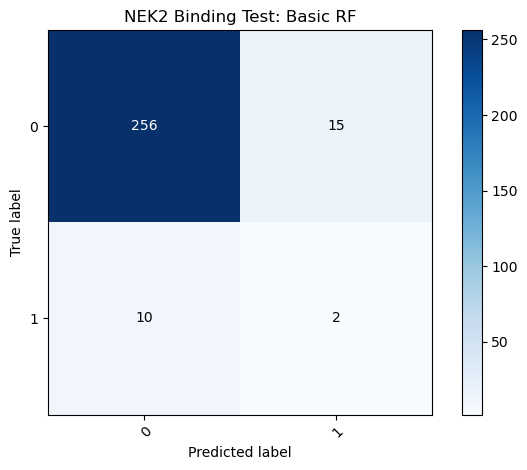

In [26]:
# # savioNEK2bind_GSCV_basicRF_best.pkl
# with open(modeldir+'atom_nek2bind_rf_basic_best.pkl', 'rb') as f: 
# # with open(modeldir+'savioNEK2bind_GSCV_basicRF_best.pkl', 'rb') as f: 
#     rf_basicbest = pickle.load(f) 
# for param, val in rf_basicbest.get_params().items(): 
#     print(f'{param} : {val}')
# train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(rf_basicbest, train_x, train_y, test_x, test_y)
# plot_confusion_matrix(test_y, test_pred, ['0','1'], title='NEK2 Bind Test: Default RF')



rf_basic100est = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {}, 'binding')
for param, val in rf_basic100est['model'].get_params().items(): 
    print(f'{param} : {val}')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, rf_basic100est['test_pred'], ['0','1'], title='NEK2 Binding Test: Basic RF')

bootstrap : False
ccp_alpha : 0.0
class_weight : balanced
criterion : gini
max_depth : 100
max_features : None
max_leaf_nodes : None
max_samples : None
min_impurity_decrease : 0.0
min_samples_leaf : 2
min_samples_split : 2
min_weight_fraction_leaf : 0.0
n_estimators : 100
n_jobs : None
oob_score : False
random_state : None
verbose : 0
warm_start : False
TRAIN: accuracy: 0.998, precision: 0.957, recall: 1.000, sensitivity: 1.000, specificity: 0.998
TEST: accuracy: 0.940, precision: 0.222, recall: 0.167, sensitivity: 0.167, specificity: 0.974


<Axes: title={'center': 'NEK2 Bind Test: RF+bal c.w'}, xlabel='Predicted label', ylabel='True label'>

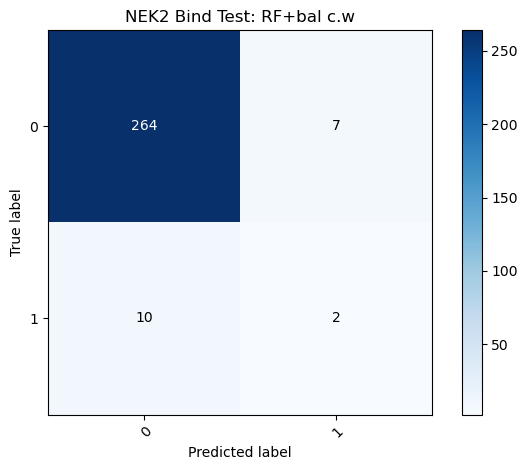

In [31]:
# with open(modeldir+'savioNEK2bind_GSCV_basicRF_best.pkl', 'rb') as f: 
with open(modeldir+'atom_nek2bind_rf_basicBCW_best.pkl', 'rb') as f: 
    rf_basicBCWbest = pickle.load(f) 
for param, val in rf_basicBCWbest.get_params().items(): 
    print(f'{param} : {val}')
train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(rf_basicBCWbest, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, test_pred, ['0','1'], title='NEK2 Bind Test: RF+bal c.w')

TRAIN: accuracy: 0.998, precision: 0.957, recall: 1.000, sensitivity: 1.000, specificity: 0.998
TEST: accuracy: 0.940, precision: 0.222, recall: 0.167, sensitivity: 0.167, specificity: 0.974


<Axes: title={'center': 'NEK2 Bind Test: RF+bal c.w'}, xlabel='Predicted label', ylabel='True label'>

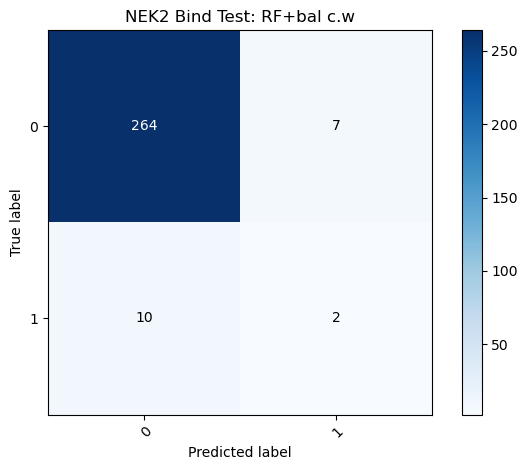

In [28]:
# with open(modeldir+'savioNEK2bind_GSCV_basicRF_best.pkl', 'rb') as f: 
with open(modeldir+'atom_nek2bind_rf_basicBCW_best.pkl', 'rb') as f: 
    rf_basicBCWbest = pickle.load(f) 
for param, val in rf_basicBCWbest.get_params().items(): 
    print(f'{param} : {val}')
train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(rf_basicBCWbest, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, test_pred, ['0','1'], title='NEK2 Bind Test: RF+bal c.w')

bootstrap : False
ccp_alpha : 0.0
class_weight : None
criterion : gini
max_depth : 20
max_features : None
max_leaf_nodes : None
max_samples : None
min_impurity_decrease : 0.0
min_samples_leaf : 5
min_samples_split : 4
min_weight_fraction_leaf : 0.0
n_estimators : 100
n_jobs : None
oob_score : False
random_state : None
verbose : 0
warm_start : False
TRAIN: accuracy: 0.974, precision: 0.786, recall: 0.489, sensitivity: 0.489, specificity: 0.994
TEST: accuracy: 0.947, precision: 0.000, recall: 0.000, sensitivity: 0.000, specificity: 0.989


<Axes: title={'center': 'NEK2 Bind Test: Balanced RF'}, xlabel='Predicted label', ylabel='True label'>

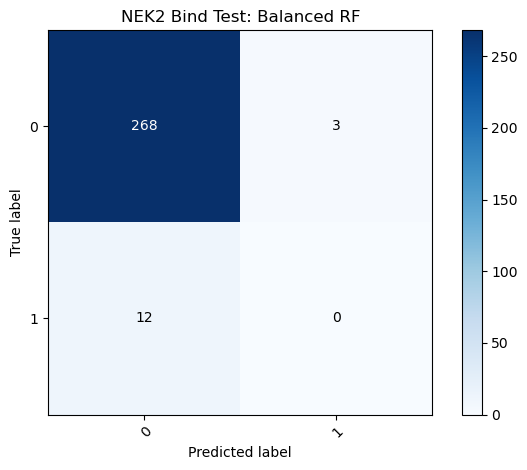

In [33]:

with open(modeldir+'atom_nek2bind_BRFC_best.pkl', 'rb') as f: 
    brfc_best = pickle.load(f) 
for param, val in brfc_best.get_params().items(): 
    print(f'{param} : {val}')
train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(brfc_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, test_pred, ['0','1'], title='NEK2 Bind Test: Balanced RF')